# Importing required modules

In [2]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix

# Loading and preprocessing data
Steps:
- loading data from csv
- shuffle data
- as input data has dictionary of features, we need to transform it to feature columns
- scaling features to (0,1)
- as its multi-class classification problem, we need to use one-hot encoding to transform labels
- splitting data into train, validation and test data sets

In [63]:
# load and shuffle the data
raw_data = pd.read_csv('fingerprints_gt_ver3.csv')
shuffled_data = shuffle(raw_data)

# transform fr_values into feature columns
features = shuffled_data['fr_values'].apply(lambda x : dict(eval(x)) ).apply(pd.Series).fillna(-100)

# scale features
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(features)

# transform zone names into one-hot labels dataset
Y = shuffled_data['zo_name'] 
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
Y = np_utils.to_categorical(encoded_Y)

# splitting data into train, cross-validation and test datasets
train_size = int(len(X) * 0.95)
valid_size = int(len(X) * 0.03)
test_size = len(X) - train_size - valid_size
valid_cutoff = train_size + valid_size
train_X, valid_X, test_X = X[0:train_size,:], X[train_size:valid_cutoff,:], X[valid_cutoff:len(X),:]
train_Y, valid_Y, test_Y = Y[0:train_size,:], Y[train_size:valid_cutoff,:], Y[valid_cutoff:len(Y),:]

print('Features shape:', X.shape)
print('One-hot lables shape:', Y.shape)
print('Train size: ', train_size, '; Validation size: ',valid_size,'; Test size: ', test_size)

Features shape: (343449, 261)
One-hot lables shape: (343449, 449)
Train size:  326276 ; Validation size:  10303 ; Test size:  6870


# Defining and training first model
First we define a simple NN with 1 hidden layer of 10 neurons <br>
- As input data has 261 features (per each wifi-node) our hidden layer has same input dimensionality
- The output layer has 449 neurons (as in dataset we have 449 different zones)
- The choice of activation function is the most general for classification problem: rectified linear unit for hidden layer and softmax for output layer (as we need multi-class output)
- The most obvious choice of loss function would be categorical_crossentropy as our labels are one-hot encoded
- We use most popular Adam optimizer here
- We track accuracy per epoch to decide on further steps

In [4]:
def simple_model():
    # create model
    model = Sequential(name='simple_model')
    model.add(Dense(10, input_dim=261, activation='relu'))
    model.add(Dense(449, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

simple_model = simple_model()

# We train model for 20 epochs and use batch size of 100 to receive initial results faster
simple_history = simple_model.fit(train_X, train_Y, epochs=20,
                  batch_size=100, validation_data=(valid_X, valid_Y),
                  verbose=0, shuffle=False)

# Performance analysis of first model
Here we plot accuracy and loss per epoch and printing F1 score to evaluate the model

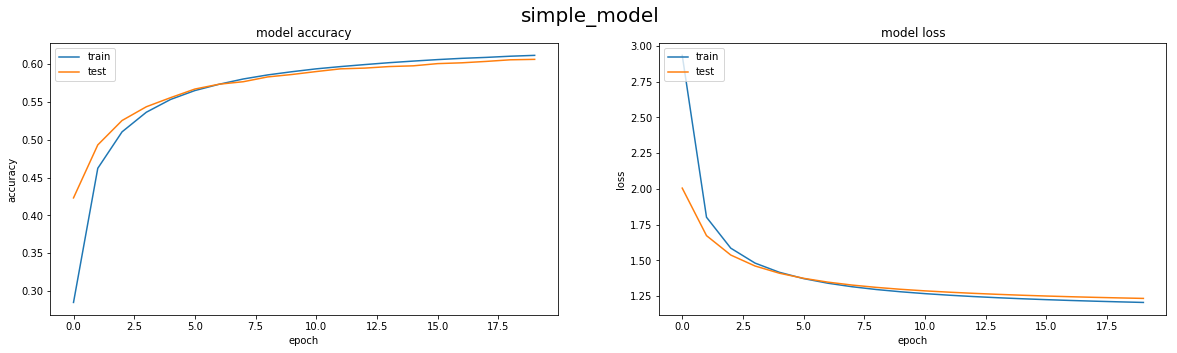

model F1 score:  0.62


In [95]:
def predict(model, data):
    y_pred = model.predict(data)
    return y_pred


def print_metrics (y_pred, Y):
    y_pred_cat = np.argmax(y_pred, axis=1)
    y_test_cat = np.argmax(Y, axis=1)
    accuracy = accuracy_score(y_test_cat, y_pred_cat)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test_cat, y_pred_cat, average='micro')
    cm = pd.DataFrame(confusion_matrix(y_test_cat, y_pred_cat))
    FP = cm.sum(axis=0) - np.diag(cm)  
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.values.sum() - (FP + FN + TP)
    metrics = {'cm':cm, 'FP':FP, 'FN':FN, 'TP':TP, 'TN':TN} 
    print("model F1 score: ", round(f1_score,2))
    return metrics  
    
def analyse(history, model):
    # summarize history for accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.suptitle(model.name, fontsize=20)

    # summarize history for loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.rcParams['figure.figsize'] = [20, 5]
    plt.show()
    
    # confusion matrix metrics
    y_pred = predict(model, valid_X)
    print_metrics(y_pred, valid_Y)
    
analyse(simple_history, simple_model)

Based on these charts we can see that our model is being trained well, it does not struggle from overfitting, but to avoid high bias problem we can try adding more features, introducing more complex features. 
- With NN we should try out higher number of neurons in hidden layer or using more layers.

# Defining and training models with more neurons and more layers

In [7]:
def wide_model():
    # create model
    model = Sequential(name='wide_model')
    model.add(Dense(50, input_dim=261, activation='relu'))
    model.add(Dense(449, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def long_model():
    # create model
    model = Sequential(name='long_model')
    model.add(Dense(10, input_dim=261, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(449, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

wide_model = wide_model()

long_model = long_model()

# Training two models
wide_history = wide_model.fit(train_X, train_Y, epochs=20,
                  batch_size=100, validation_data=(valid_X, valid_Y),
                  verbose=0, shuffle=False)
long_history = long_model.fit(train_X, train_Y, epochs=20,
                  batch_size=100, validation_data=(valid_X, valid_Y),
                  verbose=0, shuffle=False)

# Comparing performance of all 3 models

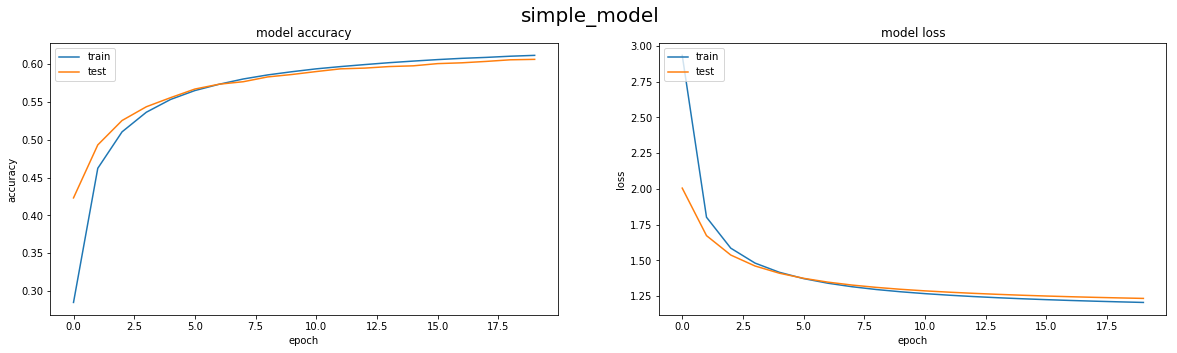

model F1 score:  0.62


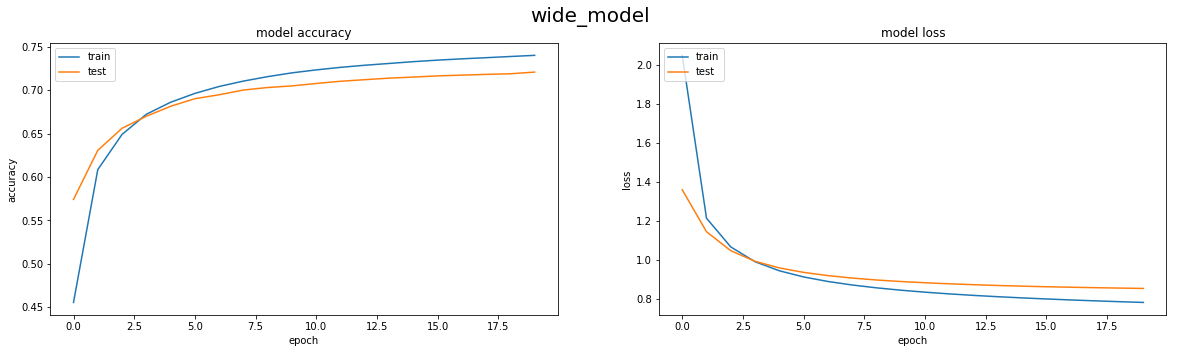

model F1 score:  0.74


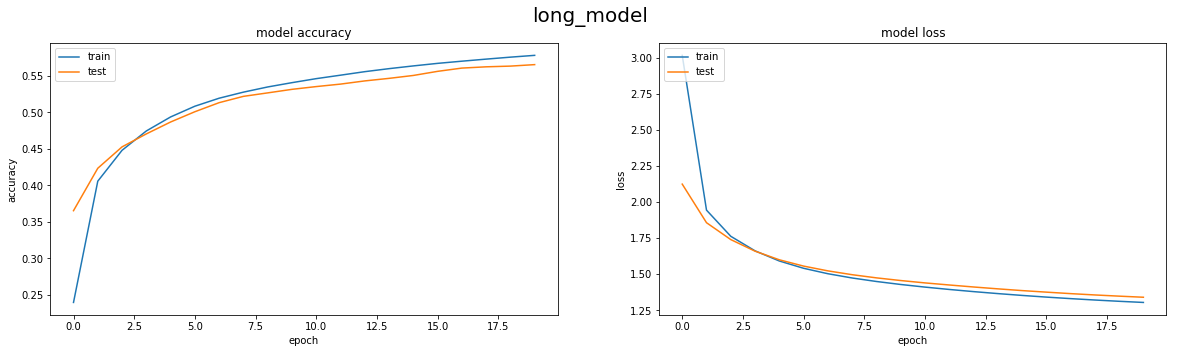

model F1 score:  0.58


In [96]:
analyse(simple_history, simple_model)
analyse(wide_history, wide_model)
analyse(long_history, long_model)

# Results

From charts and F1 score we can see that model with more neurons in hidden layer (**wide_model**) worked the best <br>
Charts as well show that training the model longer won't increase performance much <br>

Now let's see F1 score for the best model based on test dataset and 10 Best/Worst zones with their F1 score, precision and recall


In [112]:
y_pred = predict(wide_model, test_X)
y_pred_cat = np.argmax(y_pred, axis=1)
zones_pred=encoder.inverse_transform(y_pred_cat)
y_test_cat = np.argmax(test_Y, axis=1)
zones_test=encoder.inverse_transform(y_test_cat)

metrics = print_metrics (y_pred, test_Y)
TP=metrics['TP']
FN=metrics['FN']
FP=metrics['FP']
recall = TP/(TP+FN)
precision = TP/(TP+FP)
f1 = 2*precision*recall/(precision+recall)
outcome = pd.DataFrame({'recall':recall, 'precision':precision, 'F1 score':f1})
print('\n', 'Best predicted zones \n \n', 
      outcome.nlargest(10, 'F1 score'), 
      '\n \n Worst predicted zones \n \n',
      outcome.nsmallest(10, 'F1 score'))

model F1 score:  0.75

 Best predicted zones 
 
      F1 score  precision    recall
137  1.000000   1.000000  1.000000
138  1.000000   1.000000  1.000000
287  1.000000   1.000000  1.000000
309  1.000000   1.000000  1.000000
202  0.981132   0.962963  1.000000
23   0.980392   0.961538  1.000000
193  0.969697   1.000000  0.941176
136  0.967742   0.937500  1.000000
153  0.967742   1.000000  0.937500
337  0.966667   0.966667  0.966667 
 
 Worst predicted zones 
 
      F1 score  precision    recall
257  0.095238   1.000000  0.050000
67   0.125000   0.090909  0.200000
64   0.200000   1.000000  0.111111
95   0.250000   0.500000  0.166667
178  0.250000   0.200000  0.333333
397  0.250000   0.250000  0.250000
357  0.285714   0.333333  0.250000
108  0.333333   0.500000  0.250000
111  0.333333   0.500000  0.250000
387  0.333333   0.400000  0.285714


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Additionally lets see a sample of predictions on the test dataset

In [113]:
predictions = pd.DataFrame({'Prediction':zones_pred,'Real_value':zones_test})
predictions['Check']=predictions['Prediction']==predictions['Real_value']
predictions.head(10)

,Prediction,Real_value,Check
0,Zone 196,Zone 91,False
1,Zone 346,Zone 346,True
2,Zone 487,Zone 487,True
3,Zone 375,Zone 375,True
4,Zone 106,Zone 106,True
5,Zone 27,Zone 27,True
6,Zone 278,Zone 278,True
7,Zone 354,Zone 354,True
8,Zone 253,Zone 253,True
9,Zone 72,Zone 198,False
